# GalfitM process

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [15]:
img_name = 'nircam6'
prep_base = './io/prep/' + img_name + '/'
sample_base = './io/sample/' + img_name + '/'

## Prepare feedmes

In [16]:
from galfitclass import GalfitClass, SersicComponent

## Make Galfit Object with cutouts

In [17]:
sample_dir_list = glob.glob(f'./io/sample/{img_name}/EGS-*/')
sample_dir_list.sort()

customize calculate zeropoints

In [18]:
# custom
def calc_zpt(x: int, y: int)-> list:
    """
    Calculate zeropoint
    args:
        x: int
            x position

        y: int
            y position
    """
    CR = {'F115W':[0.914,0.908,0.862,0.813,0.959,0.897,0.995,0.831],
            'F150W':[1.005,0.966,0.932,0.855,1.000,0.968,0.988,0.865],
            'F200W':[0.865,0.889,0.800,0.791,0.873,0.829,0.901,0.812],
            'F277W':[1.107,1.107,1.107,1.107,1.000,1.000,1.000,1.000],
            'F356W':[1.088,1.088,1.088,1.088,1.000,1.000,1.000,1.000],
            'F410M':[1.031,1.031,1.031,1.031,1.042,1.042,1.042,1.042],
            'F444W':[1.036,1.036,1.036,1.036,1.096,1.096,1.096,1.096]
            }
    CR0 = {'F115W':[1,1,1,1,1,1,1,1],
            'F150W':[1,1,1,1,1,1,1,1],
            'F200W':[1,1,1,1,1,1,1,1],
            'F277W':[1,1,1,1,1,1,1,1],
            'F356W':[1,1,1,1,1,1,1,1],
            'F410M':[1,1,1,1,1,1,1,1],
            'F444W':[1,1,1,1,1,1,1,1]
            }
    
    let = x<5400 #letter B for left half, A for right half
    index = let << 2
    if let:
        index = index | ((x>2350) << 1) | (y>2300)
    else:
        index = index | ((x<8140) << 1) | (y<2400)
            
    #for updated version of PHOTMJSRs
    #print('zeropoints are adopted from jwst_0995.pmap\n')
    #return [28.086519392283982-2.5*np.log10(CR0[band][index]) for band in self.bands]

    #for ealier version of PHOTMJSRs
    print('Using magnitude zeropoints for F150W from Boyer et al. (2022), and for the other six filters, we use the zero points from Brammer (2022).\n')
    return [28.086519392283982-2.5*np.log10(CR[str(band)][index]) for band in CR.keys()]


In [23]:
pregalfit_path = prep_base + 'pregalfit.fits'
with fits.open(pregalfit_path) as hdul:
    hdul.info()
    tab_ini = Table(hdul['INIPARAM'].data)

Filename: ./io/prep/nircam6/pregalfit.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  IMGLIST       1 BinTableHDU     13   7R x 2C   [5A, 70A]   
  2  INIPARAM      1 BinTableHDU     39   89R x 15C   [K, 40A, D, D, D, D, D, D, D, K, D, D, D, D, D]   
  3  SEGMAP        1 ImageHDU         8   (10500, 4800)   int64   


### For single source

In [24]:
band_labels = ['F115W','F150W','F200W','F277W','F356W','F410M','F444W']
band_wavelengths = [115.40, 150.00, 198.80, 276.10, 356.80, 408.20, 440.40]
psf_list = [f'../GalfitPy3/io/psf/{band.lower()}_psf.fits' for band in band_labels]
seq = 12699
sample_dir = sample_base + f'EGS-{seq}/'
print('Processing: EGS-' + str(seq))

img_list = [sample_dir + 'sci_' + band + '.fits' for band in band_labels]
err_list = [sample_dir + 'err_' + band + '.fits' for band in band_labels]
bpmask_list = [sample_dir + 'bpmask_' + band + '.fits' for band in band_labels]

x_c = fits.getheader(img_list[0])['xc']
y_c = fits.getheader(img_list[0])['yc']
zpts = calc_zpt(x_c, y_c)

dict_band = dict(zip(band_labels, zip(band_wavelengths, zpts)))
# create a galfit object
gal_save_path = sample_dir + 'output.fits'
gal_obj = GalfitClass(dict_band, gal_save_path, plate_scale=(0.03,0.03))

gal_obj.load_data(img_list, err_list, bpmask_list)
gal_obj.load_psf(psf_list)
gal_obj.load_constraint('./constraint.txt')

# add a sersic component
sersic_comp = SersicComponent(gal_obj.nbands, skip=False)
sersic_comp.config_x(7, [gal_obj.image_size[0]/2+1]*7)
sersic_comp.config_y(7, [gal_obj.image_size[1]/2+1]*7)

row_ini = tab_ini[tab_ini['EGS-ID']==seq]
mag_ini_list = [row_ini[f'KronPhot_{band}_mag'][0] for band in band_labels]
sersic_comp.config_mag(7, mag_ini_list)
sersic_comp.config_n(2, [2.0]*2)
sersic_comp.config_re(2, [5.0]*2)
sersic_comp.config_q(1, [row_ini['eccentricity'][0]])
sersic_comp.config_pa(1, [row_ini['orientation'][0]])
    
gal_obj.add_component(sersic_comp)

# generate feedme file
feedme = gal_obj.genstr_feedme()
feedme_path = sample_dir + f'{seq}.galfit'
with open(feedme_path, 'w') as f:
    f.write(feedme)

Processing: EGS-12699
Using magnitude zeropoints for F150W from Boyer et al. (2022), and for the other six filters, we use the zero points from Brammer (2022).

SCI images loaded
ERR images loaded
Bad pixel masks loaded
PSF images loaded
Constraint file loaded


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
row_ini

EGS-ID,comment,KronPhot_F115W_mag,KronPhot_F150W_mag,KronPhot_F200W_mag,KronPhot_F277W_mag,KronPhot_F356W_mag,KronPhot_F410M_mag,KronPhot_F444W_mag,label,xcentroid,ycentroid,orientation,eccentricity,kron_radius
int64,str40,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64


### Run GalfitM

In [ ]:
gal_obj.run(feedme_path)


GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: ./io/sample/nircam1/EGS-21843/21843.galfit

# IMAGE and GALFIT CONTROL PARAMETERS
A) ./io/sample/nircam1/EGS-21843/sci_F115W.fits,./io/sample/nircam1/EGS-21843/sci_F150W.fits,./io/sample/nircam1/EGS-21843/sci_F200W.fits,./io/sample/nircam1/EGS-21843/sci_F277W.fits,./io/sample/nircam1/EGS-21843/sci_F356W.fits,./io/sample/nircam1/EGS-21843/sci_F410M.fits,./io/sample/nircam1/EGS-21843/sci_F444W.fits      # Input data image (FITS file)
A1) F115W,F150W,F200W,F277W,F356W,F410M,F444W     # Band labels
A2) 115.400,150.000,198.800,276.100,356.800,408.200,440.400     # Band wavelengths
B) ./io/sample/nircam1/EGS-21843/output.fits      # Output data image block
C) ./io/sample/nircam1/EGS-21843/err_F115W.fits,./io/sample/nircam1/EGS-21843/err_F150W.fits,./io/sample/nircam1/EGS-21843/err_F200W.fits,./io/sample/nircam1/EGS-21843/err_F277W.fits,./io/sample/nircam1/EGS-21843/err_F356W.fits,./io/sample/nircam1/EGS-2184

## Check GalfitM Result

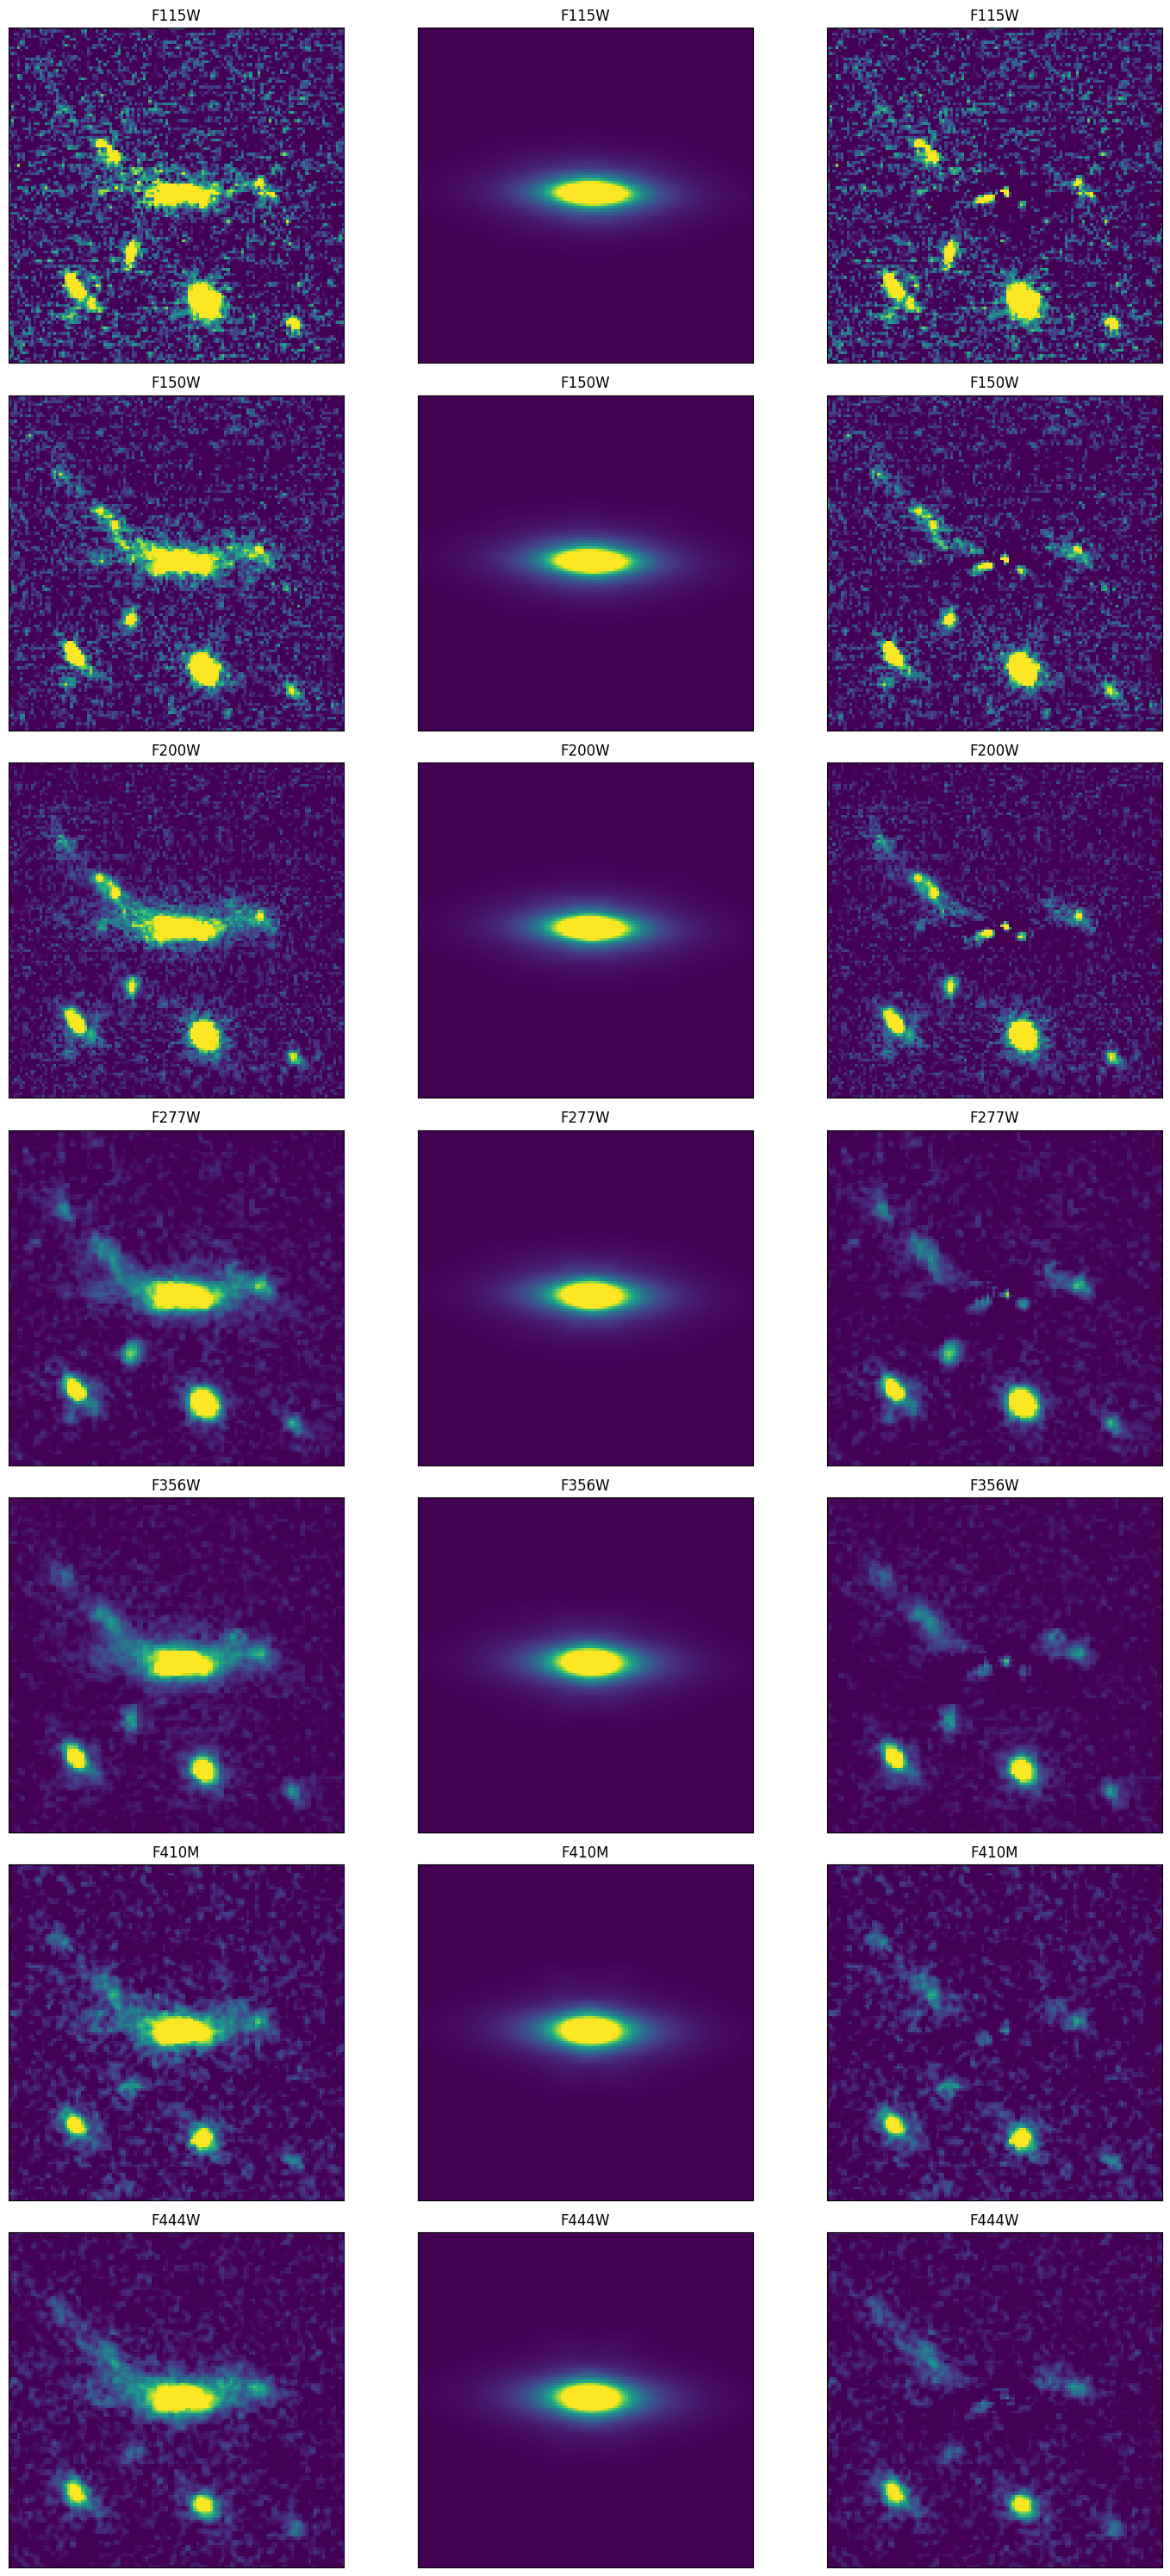

EGS-21843


In [ ]:
fig, ax = plt.subplots(7,3,figsize=(15,30),sharex=True,sharey=True)
with fits.open(sample_dir + 'output.fits') as hdul:
    for i in range(7):
        for j in [1,0,2]:
            ax_data = hdul[1+j*7+i].data
            if j==1:
                vmin = np.percentile(ax_data,60)
                vmax = np.percentile(ax_data,99)
            ax[i,j].imshow(ax_data,origin='lower',vmin=vmin,vmax=vmax,cmap='viridis')
            ax[i,j].set_title(band_labels[i])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
plt.tight_layout()
plt.show()
print(sample_dir.split('/')[-2])